In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
num_classes = 7

In [4]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [9]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((280, 218))
])

#dataset_str = 'cropped_images'
#dataset_str = 'cropped_processed_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'
#dataset_str = 'cropped_rotated_processed_images_3'
#dataset_str = 'cropped_rotated_processed_images_4'
#dataset_str = "cropped_rotated_processed_images_5"
dataset_str = "cropped_rotated_processed_images_6"

training_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=0)

testing_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=10, shuffle=True, num_workers=0)

In [10]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [11]:
model = model.to(device)

In [12]:
results_dir = 'results/'

In [13]:
import csv
csv_header = ['Classification loss']

csvfile = open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [14]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                    print(
                        f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                    )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 14 / 20 with accuracy 70.00
Got 20 / 30 with accuracy 66.67
Got 23 / 40 with accuracy 57.50
Got 31 / 50 with accuracy 62.00
Got 39 / 60 with accuracy 65.00
Got 46 / 70 with accuracy 65.71
Got 49 / 80 with accuracy 61.25
Got 59 / 90 with accuracy 65.56
Got 67 / 100 with accuracy 67.00
Got 73 / 110 with accuracy 66.36
Got 81 / 120 with accuracy 67.50
Got 87 / 130 with accuracy 66.92
Got 95 / 140 with accuracy 67.86
Got 100 / 150 with accuracy 66.67
Got 107 / 160 with accuracy 66.88
Got 112 / 170 with accuracy 65.88
Got 119 / 180 with accuracy 66.11
Got 126 / 190 with accuracy 66.32
Got 129 / 196 with accuracy 65.82
----------
Epoch 1/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 42 / 50 with accuracy 84.00
Got 51 / 60 with accuracy 85.00
Got 55 / 70 with accuracy 78.57
Got 64 / 80 with accuracy 80.00
Got 72 / 90 with accuracy 80.00
Got 81 / 100 with accuracy 81.00
Got 88 / 110 with accuracy 80.00
Got 95 / 120 with accuracy 79.17
Got 103 / 130 with accuracy 79.23
Got 110 / 140 with accuracy 78.57
Got 120 / 150 with accuracy 80.00
Got 129 / 160 with accuracy 80.62
Got 137 / 170 with accuracy 80.59
Got 147 / 180 with accuracy 81.67
Got 155 / 190 with accuracy 81.58
Got 160 / 196 with accuracy 81.63
----------
Epoch 2/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 5 / 10 with accuracy 50.00
Got 15 / 20 with accuracy 75.00
Got 23 / 30 with accuracy 76.67
Got 31 / 40 with accuracy 77.50
Got 41 / 50 with accuracy 82.00
Got 51 / 60 with accuracy 85.00
Got 60 / 70 with accuracy 85.71
Got 69 / 80 with accuracy 86.25
Got 78 / 90 with accuracy 86.67
Got 88 / 100 with accuracy 88.00
Got 97 / 110 with accuracy 88.18
Got 106 / 120 with accuracy 88.33
Got 114 / 130 with accuracy 87.69
Got 124 / 140 with accuracy 88.57
Got 134 / 150 with accuracy 89.33
Got 143 / 160 with accuracy 89.38
Got 153 / 170 with accuracy 90.00
Got 163 / 180 with accuracy 90.56
Got 171 / 190 with accuracy 90.00
Got 177 / 196 with accuracy 90.31
----------
Epoch 3/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 42 / 50 with accuracy 84.00
Got 51 / 60 with accuracy 85.00
Got 61 / 70 with accuracy 87.14
Got 69 / 80 with accuracy 86.25
Got 79 / 90 with accuracy 87.78
Got 88 / 100 with accuracy 88.00
Got 98 / 110 with accuracy 89.09
Got 108 / 120 with accuracy 90.00
Got 116 / 130 with accuracy 89.23
Got 125 / 140 with accuracy 89.29
Got 134 / 150 with accuracy 89.33
Got 143 / 160 with accuracy 89.38
Got 152 / 170 with accuracy 89.41
Got 161 / 180 with accuracy 89.44
Got 170 / 190 with accuracy 89.47
Got 176 / 196 with accuracy 89.80
----------
Epoch 4/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 17 / 20 with accuracy 85.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 46 / 50 with accuracy 92.00
Got 54 / 60 with accuracy 90.00
Got 64 / 70 with accuracy 91.43
Got 74 / 80 with accuracy 92.50
Got 82 / 90 with accuracy 91.11
Got 92 / 100 with accuracy 92.00
Got 102 / 110 with accuracy 92.73
Got 112 / 120 with accuracy 93.33
Got 121 / 130 with accuracy 93.08
Got 131 / 140 with accuracy 93.57
Got 141 / 150 with accuracy 94.00
Got 149 / 160 with accuracy 93.12
Got 159 / 170 with accuracy 93.53
Got 168 / 180 with accuracy 93.33
Got 178 / 190 with accuracy 93.68
Got 183 / 196 with accuracy 93.37
----------
Epoch 5/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 44 / 50 with accuracy 88.00
Got 52 / 60 with accuracy 86.67
Got 62 / 70 with accuracy 88.57
Got 69 / 80 with accuracy 86.25
Got 79 / 90 with accuracy 87.78
Got 87 / 100 with accuracy 87.00
Got 95 / 110 with accuracy 86.36
Got 102 / 120 with accuracy 85.00
Got 112 / 130 with accuracy 86.15
Got 120 / 140 with accuracy 85.71
Got 129 / 150 with accuracy 86.00
Got 136 / 160 with accuracy 85.00
Got 146 / 170 with accuracy 85.88
Got 154 / 180 with accuracy 85.56
Got 161 / 190 with accuracy 84.74
Got 165 / 196 with accuracy 84.18
----------
Epoch 6/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 16 / 20 with accuracy 80.00
Got 24 / 30 with accuracy 80.00
Got 32 / 40 with accuracy 80.00
Got 40 / 50 with accuracy 80.00
Got 48 / 60 with accuracy 80.00
Got 55 / 70 with accuracy 78.57
Got 65 / 80 with accuracy 81.25
Got 73 / 90 with accuracy 81.11
Got 81 / 100 with accuracy 81.00
Got 91 / 110 with accuracy 82.73
Got 98 / 120 with accuracy 81.67
Got 108 / 130 with accuracy 83.08
Got 117 / 140 with accuracy 83.57
Got 125 / 150 with accuracy 83.33
Got 130 / 160 with accuracy 81.25
Got 137 / 170 with accuracy 80.59
Got 146 / 180 with accuracy 81.11
Got 153 / 190 with accuracy 80.53
Got 158 / 196 with accuracy 80.61
----------
Epoch 7/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 27 / 30 with accuracy 90.00
Got 36 / 40 with accuracy 90.00
Got 46 / 50 with accuracy 92.00
Got 56 / 60 with accuracy 93.33
Got 65 / 70 with accuracy 92.86
Got 73 / 80 with accuracy 91.25
Got 83 / 90 with accuracy 92.22
Got 91 / 100 with accuracy 91.00
Got 100 / 110 with accuracy 90.91
Got 109 / 120 with accuracy 90.83
Got 118 / 130 with accuracy 90.77
Got 125 / 140 with accuracy 89.29
Got 134 / 150 with accuracy 89.33
Got 142 / 160 with accuracy 88.75
Got 151 / 170 with accuracy 88.82
Got 161 / 180 with accuracy 89.44
Got 170 / 190 with accuracy 89.47
Got 176 / 196 with accuracy 89.80
----------
Epoch 8/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 26 / 30 with accuracy 86.67
Got 36 / 40 with accuracy 90.00
Got 46 / 50 with accuracy 92.00
Got 56 / 60 with accuracy 93.33
Got 66 / 70 with accuracy 94.29
Got 75 / 80 with accuracy 93.75
Got 85 / 90 with accuracy 94.44
Got 94 / 100 with accuracy 94.00
Got 104 / 110 with accuracy 94.55
Got 114 / 120 with accuracy 95.00
Got 123 / 130 with accuracy 94.62
Got 132 / 140 with accuracy 94.29
Got 142 / 150 with accuracy 94.67
Got 152 / 160 with accuracy 95.00
Got 162 / 170 with accuracy 95.29
Got 172 / 180 with accuracy 95.56
Got 179 / 190 with accuracy 94.21
Got 185 / 196 with accuracy 94.39
----------
Epoch 9/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 24 / 30 with accuracy 80.00
Got 33 / 40 with accuracy 82.50
Got 40 / 50 with accuracy 80.00
Got 48 / 60 with accuracy 80.00
Got 58 / 70 with accuracy 82.86
Got 68 / 80 with accuracy 85.00
Got 78 / 90 with accuracy 86.67
Got 86 / 100 with accuracy 86.00
Got 94 / 110 with accuracy 85.45
Got 103 / 120 with accuracy 85.83
Got 110 / 130 with accuracy 84.62
Got 117 / 140 with accuracy 83.57
Got 127 / 150 with accuracy 84.67
Got 136 / 160 with accuracy 85.00
Got 145 / 170 with accuracy 85.29
Got 154 / 180 with accuracy 85.56
Got 164 / 190 with accuracy 86.32
Got 169 / 196 with accuracy 86.22
----------
Epoch 10/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 26 / 30 with accuracy 86.67
Got 36 / 40 with accuracy 90.00
Got 45 / 50 with accuracy 90.00
Got 55 / 60 with accuracy 91.67
Got 65 / 70 with accuracy 92.86
Got 75 / 80 with accuracy 93.75
Got 83 / 90 with accuracy 92.22
Got 93 / 100 with accuracy 93.00
Got 101 / 110 with accuracy 91.82
Got 111 / 120 with accuracy 92.50
Got 121 / 130 with accuracy 93.08
Got 130 / 140 with accuracy 92.86
Got 139 / 150 with accuracy 92.67
Got 148 / 160 with accuracy 92.50
Got 156 / 170 with accuracy 91.76
Got 165 / 180 with accuracy 91.67
Got 174 / 190 with accuracy 91.58
Got 180 / 196 with accuracy 91.84
----------
Epoch 11/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 18 / 20 with accuracy 90.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 45 / 50 with accuracy 90.00
Got 54 / 60 with accuracy 90.00
Got 64 / 70 with accuracy 91.43
Got 74 / 80 with accuracy 92.50
Got 84 / 90 with accuracy 93.33
Got 94 / 100 with accuracy 94.00
Got 103 / 110 with accuracy 93.64
Got 112 / 120 with accuracy 93.33
Got 119 / 130 with accuracy 91.54
Got 129 / 140 with accuracy 92.14
Got 138 / 150 with accuracy 92.00
Got 146 / 160 with accuracy 91.25
Got 156 / 170 with accuracy 91.76
Got 165 / 180 with accuracy 91.67
Got 175 / 190 with accuracy 92.11
Got 181 / 196 with accuracy 92.35
----------
Epoch 12/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 55 / 60 with accuracy 91.67
Got 65 / 70 with accuracy 92.86
Got 73 / 80 with accuracy 91.25
Got 82 / 90 with accuracy 91.11
Got 89 / 100 with accuracy 89.00
Got 99 / 110 with accuracy 90.00
Got 108 / 120 with accuracy 90.00
Got 118 / 130 with accuracy 90.77
Got 127 / 140 with accuracy 90.71
Got 136 / 150 with accuracy 90.67
Got 145 / 160 with accuracy 90.62
Got 155 / 170 with accuracy 91.18
Got 163 / 180 with accuracy 90.56
Got 173 / 190 with accuracy 91.05
Got 179 / 196 with accuracy 91.33
----------
Epoch 13/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 46 / 50 with accuracy 92.00
Got 56 / 60 with accuracy 93.33
Got 65 / 70 with accuracy 92.86
Got 75 / 80 with accuracy 93.75
Got 84 / 90 with accuracy 93.33
Got 92 / 100 with accuracy 92.00
Got 101 / 110 with accuracy 91.82
Got 109 / 120 with accuracy 90.83
Got 115 / 130 with accuracy 88.46
Got 124 / 140 with accuracy 88.57
Got 133 / 150 with accuracy 88.67
Got 142 / 160 with accuracy 88.75
Got 152 / 170 with accuracy 89.41
Got 161 / 180 with accuracy 89.44
Got 171 / 190 with accuracy 90.00
Got 177 / 196 with accuracy 90.31
----------
Epoch 14/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 16 / 20 with accuracy 80.00
Got 23 / 30 with accuracy 76.67
Got 33 / 40 with accuracy 82.50
Got 43 / 50 with accuracy 86.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 72 / 80 with accuracy 90.00
Got 82 / 90 with accuracy 91.11
Got 92 / 100 with accuracy 92.00
Got 102 / 110 with accuracy 92.73
Got 112 / 120 with accuracy 93.33
Got 121 / 130 with accuracy 93.08
Got 131 / 140 with accuracy 93.57
Got 141 / 150 with accuracy 94.00
Got 150 / 160 with accuracy 93.75
Got 159 / 170 with accuracy 93.53
Got 168 / 180 with accuracy 93.33
Got 178 / 190 with accuracy 93.68
Got 183 / 196 with accuracy 93.37
----------
Epoch 15/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 39 / 40 with accuracy 97.50
Got 49 / 50 with accuracy 98.00
Got 58 / 60 with accuracy 96.67
Got 68 / 70 with accuracy 97.14
Got 78 / 80 with accuracy 97.50
Got 87 / 90 with accuracy 96.67
Got 94 / 100 with accuracy 94.00
Got 104 / 110 with accuracy 94.55
Got 113 / 120 with accuracy 94.17
Got 122 / 130 with accuracy 93.85
Got 132 / 140 with accuracy 94.29
Got 142 / 150 with accuracy 94.67
Got 151 / 160 with accuracy 94.38
Got 160 / 170 with accuracy 94.12
Got 170 / 180 with accuracy 94.44
Got 179 / 190 with accuracy 94.21
Got 184 / 196 with accuracy 93.88
----------
Epoch 16/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 29 / 30 with accuracy 96.67
Got 39 / 40 with accuracy 97.50
Got 48 / 50 with accuracy 96.00
Got 58 / 60 with accuracy 96.67
Got 67 / 70 with accuracy 95.71
Got 75 / 80 with accuracy 93.75
Got 84 / 90 with accuracy 93.33
Got 94 / 100 with accuracy 94.00
Got 104 / 110 with accuracy 94.55
Got 114 / 120 with accuracy 95.00
Got 123 / 130 with accuracy 94.62
Got 133 / 140 with accuracy 95.00
Got 142 / 150 with accuracy 94.67
Got 152 / 160 with accuracy 95.00
Got 161 / 170 with accuracy 94.71
Got 171 / 180 with accuracy 95.00
Got 181 / 190 with accuracy 95.26
Got 187 / 196 with accuracy 95.41
----------
Epoch 17/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 29 / 30 with accuracy 96.67
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 57 / 60 with accuracy 95.00
Got 65 / 70 with accuracy 92.86
Got 74 / 80 with accuracy 92.50
Got 82 / 90 with accuracy 91.11
Got 91 / 100 with accuracy 91.00
Got 100 / 110 with accuracy 90.91
Got 109 / 120 with accuracy 90.83
Got 119 / 130 with accuracy 91.54
Got 129 / 140 with accuracy 92.14
Got 136 / 150 with accuracy 90.67
Got 146 / 160 with accuracy 91.25
Got 154 / 170 with accuracy 90.59
Got 163 / 180 with accuracy 90.56
Got 171 / 190 with accuracy 90.00
Got 176 / 196 with accuracy 89.80
----------
Epoch 18/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 38 / 40 with accuracy 95.00
Got 48 / 50 with accuracy 96.00
Got 58 / 60 with accuracy 96.67
Got 68 / 70 with accuracy 97.14
Got 78 / 80 with accuracy 97.50
Got 86 / 90 with accuracy 95.56
Got 95 / 100 with accuracy 95.00
Got 104 / 110 with accuracy 94.55
Got 111 / 120 with accuracy 92.50
Got 119 / 130 with accuracy 91.54
Got 128 / 140 with accuracy 91.43
Got 138 / 150 with accuracy 92.00
Got 148 / 160 with accuracy 92.50
Got 157 / 170 with accuracy 92.35
Got 165 / 180 with accuracy 91.67
Got 174 / 190 with accuracy 91.58
Got 180 / 196 with accuracy 91.84
----------
Epoch 19/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 46 / 50 with accuracy 92.00
Got 54 / 60 with accuracy 90.00
Got 63 / 70 with accuracy 90.00
Got 72 / 80 with accuracy 90.00
Got 81 / 90 with accuracy 90.00
Got 89 / 100 with accuracy 89.00
Got 99 / 110 with accuracy 90.00
Got 107 / 120 with accuracy 89.17
Got 116 / 130 with accuracy 89.23
Got 123 / 140 with accuracy 87.86
Got 132 / 150 with accuracy 88.00
Got 142 / 160 with accuracy 88.75
Got 152 / 170 with accuracy 89.41
Got 161 / 180 with accuracy 89.44
Got 169 / 190 with accuracy 88.95
Got 173 / 196 with accuracy 88.27


In [15]:
csvfile.close()

In [16]:
best_acc

95.40816326530613

In [17]:
torch.save(best_model_wts, f'salvataggi_pytorch/{dataset_str}_model_state_dict')

In [18]:
model.load_state_dict(torch.load(f'salvataggi_pytorch/{dataset_str}_model_state_dict'))
model.to(torch.device('cpu'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [19]:
testloader = DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=True, num_workers=0)

In [20]:
dataiter = iter(testloader)
x, y = next(dataiter)
scores = model(x)
predictions = scores.argmax(1)

In [21]:
predictions

tensor([0, 4, 6, 4, 6, 3, 0, 3, 6, 3, 5, 3, 0, 3, 6, 5, 2, 0, 1, 5, 5, 0, 5, 4,
        2, 6, 6, 1, 6, 5, 3, 6, 1, 1, 3, 1, 5, 0, 2, 5, 6, 3, 0, 0, 5, 4, 3, 3,
        0, 1, 4, 1, 3, 1, 5, 5, 4, 5, 3, 2, 2, 5, 4, 6, 1, 5, 4, 4, 6, 4, 0, 0,
        1, 1, 2, 4, 0, 0, 1, 2, 6, 2, 1, 5, 1, 2, 1, 5, 6, 0, 3, 1, 1, 6, 0, 6,
        6, 0, 4, 5, 1, 2, 5, 0, 4, 4, 6, 1, 6, 5, 1, 0, 3, 2, 4, 6, 4, 4, 3, 6,
        6, 0, 1, 4, 1, 0, 6, 2, 6, 6, 2, 0, 4, 2, 5, 6, 2, 2, 3, 2, 4, 5, 4, 2,
        6, 1, 1, 5, 2, 6, 1, 1, 2, 5, 2, 3, 5, 4, 5, 2, 1, 1, 1, 3, 2, 1, 4, 1,
        3, 6, 1, 6, 6, 0, 5, 6, 5, 1, 0, 0, 4, 1, 6, 0, 6, 4, 6, 4, 4, 3, 4, 5,
        5, 0, 4, 3])

In [22]:
y

tensor([0, 4, 6, 4, 6, 3, 0, 3, 6, 3, 5, 2, 0, 3, 6, 5, 2, 0, 1, 5, 5, 0, 5, 4,
        2, 6, 6, 1, 6, 5, 3, 6, 1, 1, 3, 1, 5, 0, 2, 5, 6, 3, 0, 0, 5, 4, 3, 3,
        4, 1, 4, 1, 3, 1, 5, 5, 4, 5, 3, 2, 2, 5, 4, 6, 1, 0, 4, 4, 6, 4, 3, 0,
        1, 1, 2, 4, 0, 0, 1, 2, 6, 2, 5, 5, 1, 2, 1, 5, 6, 0, 3, 1, 1, 6, 3, 6,
        6, 4, 4, 5, 1, 2, 5, 0, 4, 4, 6, 1, 6, 5, 1, 0, 3, 2, 4, 6, 4, 4, 3, 6,
        6, 0, 1, 4, 1, 0, 6, 2, 6, 6, 2, 0, 4, 2, 5, 6, 2, 2, 3, 2, 4, 5, 4, 2,
        6, 1, 1, 5, 2, 6, 1, 1, 2, 5, 2, 3, 5, 4, 6, 2, 1, 1, 1, 3, 2, 1, 4, 1,
        3, 6, 1, 6, 6, 3, 5, 6, 5, 1, 0, 0, 4, 1, 6, 0, 6, 4, 6, 4, 4, 3, 4, 5,
        5, 0, 4, 3])

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame({'predictions': predictions.cpu().numpy(), 'y_true': y.cpu().numpy()})
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,0,0
1,4,4
2,6,6
3,4,4
4,6,6
...,...,...
191,5,5
192,5,5
193,0,0
194,4,4


In [25]:
preds = df['predictions'].values
preds

array([0, 4, 6, 4, 6, 3, 0, 3, 6, 3, 5, 3, 0, 3, 6, 5, 2, 0, 1, 5, 5, 0,
       5, 4, 2, 6, 6, 1, 6, 5, 3, 6, 1, 1, 3, 1, 5, 0, 2, 5, 6, 3, 0, 0,
       5, 4, 3, 3, 0, 1, 4, 1, 3, 1, 5, 5, 4, 5, 3, 2, 2, 5, 4, 6, 1, 5,
       4, 4, 6, 4, 0, 0, 1, 1, 2, 4, 0, 0, 1, 2, 6, 2, 1, 5, 1, 2, 1, 5,
       6, 0, 3, 1, 1, 6, 0, 6, 6, 0, 4, 5, 1, 2, 5, 0, 4, 4, 6, 1, 6, 5,
       1, 0, 3, 2, 4, 6, 4, 4, 3, 6, 6, 0, 1, 4, 1, 0, 6, 2, 6, 6, 2, 0,
       4, 2, 5, 6, 2, 2, 3, 2, 4, 5, 4, 2, 6, 1, 1, 5, 2, 6, 1, 1, 2, 5,
       2, 3, 5, 4, 5, 2, 1, 1, 1, 3, 2, 1, 4, 1, 3, 6, 1, 6, 6, 0, 5, 6,
       5, 1, 0, 0, 4, 1, 6, 0, 6, 4, 6, 4, 4, 3, 4, 5, 5, 0, 4, 3],
      dtype=int64)

In [26]:
y_true = df['y_true'].values
y_true

array([0, 4, 6, 4, 6, 3, 0, 3, 6, 3, 5, 2, 0, 3, 6, 5, 2, 0, 1, 5, 5, 0,
       5, 4, 2, 6, 6, 1, 6, 5, 3, 6, 1, 1, 3, 1, 5, 0, 2, 5, 6, 3, 0, 0,
       5, 4, 3, 3, 4, 1, 4, 1, 3, 1, 5, 5, 4, 5, 3, 2, 2, 5, 4, 6, 1, 0,
       4, 4, 6, 4, 3, 0, 1, 1, 2, 4, 0, 0, 1, 2, 6, 2, 5, 5, 1, 2, 1, 5,
       6, 0, 3, 1, 1, 6, 3, 6, 6, 4, 4, 5, 1, 2, 5, 0, 4, 4, 6, 1, 6, 5,
       1, 0, 3, 2, 4, 6, 4, 4, 3, 6, 6, 0, 1, 4, 1, 0, 6, 2, 6, 6, 2, 0,
       4, 2, 5, 6, 2, 2, 3, 2, 4, 5, 4, 2, 6, 1, 1, 5, 2, 6, 1, 1, 2, 5,
       2, 3, 5, 4, 6, 2, 1, 1, 1, 3, 2, 1, 4, 1, 3, 6, 1, 6, 6, 3, 5, 6,
       5, 1, 0, 0, 4, 1, 6, 0, 6, 4, 6, 4, 4, 3, 4, 5, 5, 0, 4, 3],
      dtype=int64)

In [27]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [28]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [29]:
results_dict

{'A': [21, 22],
 'B': [33, 33],
 'C': [23, 24],
 'D': [20, 23],
 'E': [29, 31],
 'F': [27, 28],
 'G': [34, 35]}

In [30]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,21,22
B,33,33
C,23,24
D,20,23
E,29,31
F,27,28
G,34,35


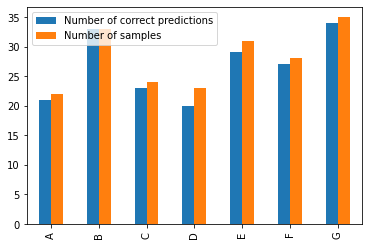

In [31]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [33]:
print(confusion_matrix(y_true, preds))

[[21  0  0  0  0  1  0]
 [ 0 33  0  0  0  0  0]
 [ 0  0 23  1  0  0  0]
 [ 3  0  0 20  0  0  0]
 [ 2  0  0  0 29  0  0]
 [ 0  1  0  0  0 27  0]
 [ 0  0  0  0  0  1 34]]


In [34]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.9540816326530612

In [35]:
with open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [36]:
precision = precision_score(y_true, preds, average=None)
precision

array([0.80769231, 0.97058824, 1.        , 0.95238095, 1.        ,
       0.93103448, 1.        ])

In [37]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.95454545, 1.        , 0.95833333, 0.86956522, 0.93548387,
       0.96428571, 0.97142857])

In [38]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.875     , 0.98507463, 0.9787234 , 0.90909091, 0.96666667,
       0.94736842, 0.98550725])

In [39]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,0.807692,0.954545,0.875000
B,0.970588,1.000000,0.985075
C,1.000000,0.958333,0.978723
D,0.952381,0.869565,0.909091
E,1.000000,0.935484,0.966667
F,0.931034,0.964286,0.947368
G,1.000000,0.971429,0.985507


<AxesSubplot:>

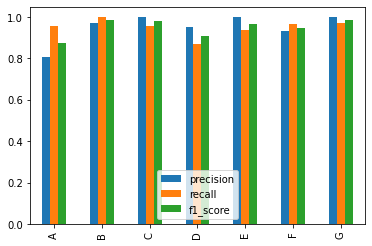

In [40]:
df.plot.bar()